In [7]:
import sys
import pandas as pd
import numpy as np
import os
import datetime as DT
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import rbf_functions

rbfs = [rbf_functions.original_rbf,
        rbf_functions.squared_exponential_rbf,
        rbf_functions.inverse_quadratic_rbf,
        rbf_functions.inverse_multiquadric_rbf,
        rbf_functions.exponential_rbf,
        rbf_functions.matern32_rbf,
        rbf_functions.matern52_rbf,
       ]

In [3]:
# output_dir = f"../output/{rbf}/"



nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
#             nfearchive[name][i.split("_")[0]] = pd.read_csv(output_dir + i)
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes[0::10]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [ ]:
# for name in nfearchive:
#     for s in nfearchive[name]:
#         print(f"{name} seed {s} rows: {nfearchive[name][s]['0'].count()}")

In [ ]:
# archives_by_nfe = nfearchive['squared_exponential_rbf']['20']
# print(f"rows: {archives_by_nfe['0'].count()}")
# nfes = archives_by_nfe["Unnamed: 0"].values
# u_nfes = np.unique(nfes)
# selected_nfe = u_nfes[0::5]
# archives_by_nfe = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe )]
# print(f"Selected: {len(selected_nfe)} nfe generations:")
# print(selected_nfe)
# print(f"rows: {archives_by_nfe['0'].count()}")
# archives_by_nfe.head()

In [ ]:
archives_by_nfe = pd.read_csv(output_dir + '10_hypervolume.csv')
print(f"rows: {archives_by_nfe['0'].count()}")

nfes = archives_by_nfe["Unnamed: 0"].values
u_nfes = np.unique(nfes)
selected_nfe = u_nfes[0::5]
archives_by_nfe = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe )]

print(f"Selected: {len(selected_nfe)} nfe generations:")
print(selected_nfe)
print(f"rows: {archives_by_nfe['0'].count()}")
archives_by_nfe.head()


we need to transform the dataframe back into platypus solution instances.

We need to have a collection of solutions for each generation


In [ ]:
# for s in nfearchive['squared_exponential_rbf']:


In [4]:
from platypus import Solution, Problem, Hypervolume

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive
        

in this case our reference set is the final set of solutions (only a single seed). So let's load this data as well and turn it into a set of solution in the same way as we did with the archives.

In [5]:
ref_dir = "../refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f'{ref_dir}{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

In [ ]:
# data = pd.read_csv(output_dir + '10_solution.csv')
#     ref_set = []
#     for i, row in data.iterrows():
#         solution = Solution(problem)
#         solution.objectives = row
#         ref_set.append(solution)

for rbf in archives:
    print(rbf)
#     for seed in archives[rbf]:
#         archive = archives[rbf][seed]

In [6]:
rbf = "squared_exponential_rbf"
nfe_sets = {}
hv_sets = {}
tempnfe = {}
temphv = {}
# for rbf in archives:
nfe_sets[rbf] = {}
hv_sets[rbf] = {}
hv = Hypervolume(reference_set=ref_sets[rbf])
print(f"started {rbf} at {DT.datetime.now()}")
for seed in archives["squared_exponential_rbf"]:
    nfe_sets[rbf][seed] = {}
    hv_sets[rbf][seed] = {}
    s_archives = archives[rbf][seed]
    nfes = []
    hvs = []
    for nfe, archive in s_archives.items():
        nfes.append(nfe)
        hvs.append(hv.calculate(archive))
    nfe_sets[rbf][seed] = nfes
    hv_sets[rbf][seed] = hvs
    tempnfe[seed] = nfes
    temphv[seed] = hvs
    dfhv = pd.DataFrame.from_dict(temphv, orient='index')
    dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
    dfhv = dfhv.T
    dfnfe = dfnfe.T
    dfhv.to_csv(f"{rbf}_hv.csv", index=False)
    dfnfe.to_csv(f"{rbf}_hv_nfe.csv", index=False)
    print(f"finished seed: {seed} at {DT.datetime.now()}")


started squared_exponential_rbf at 2021-12-21 23:07:09.321419
finished seed: 10 at 2021-12-22 00:24:52.464071
finished seed: 20 at 2021-12-22 03:56:41.782814
finished seed: 30 at 2021-12-22 04:24:18.828580
finished seed: 40 at 2021-12-22 05:37:06.879910
finished seed: 50 at 2021-12-22 06:31:42.371526
finished seed: 60 at 2021-12-22 08:39:33.663782
finished seed: 70 at 2021-12-22 18:54:19.346869
finished seed: 80 at 2021-12-22 19:43:31.915202
finished seed: 90 at 2021-12-22 22:26:10.517025
finished seed: 100 at 2021-12-22 23:10:28.679596


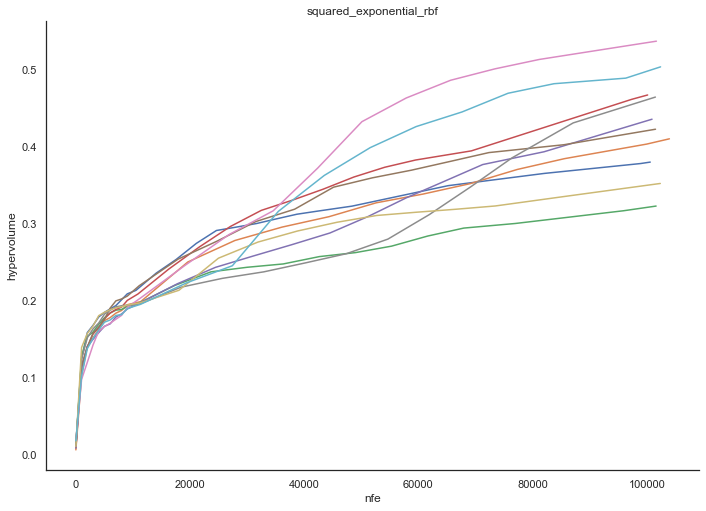

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
rbf = 'squared_exponential_rbf'

fig, ax = plt.subplots(sharex=True)
for i in nfe_sets[rbf]:
    ax.plot(nfe_sets[rbf][i], hv_sets[rbf][i])

ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax.set_title(rbf)
sns.despine()

plt.show()

In [14]:
dft_hv = pd.read_csv(f"{rbf}_hv.csv")
dft_nfe = pd.read_csv(f"{rbf}_hv_nfe.csv")

In [12]:
ep_nfe = {}
ep_improv = {}
output_dir = f"../output/{rbf}/"
for i in os.listdir(output_dir):
    if i.endswith("_convergence.csv"):
        ep_load = pd.read_csv(output_dir + i)
        ep_nfe[int(i.split("_")[0])] = ep_load.nfe
        ep_improv[int(i.split("_")[0])]  = ep_load.improvements
ep_nfe = pd.DataFrame.from_dict(ep_nfe)
ep_improv = pd.DataFrame.from_dict(ep_improv)

In [ ]:
fig, ax = plt.subplots()
ax.plot(e_progress.nfe, e_progress.improvements)
ax.set_xlabel('nfe')
ax.set_ylabel('epsilon progress')
sns.despine()

plt.show()

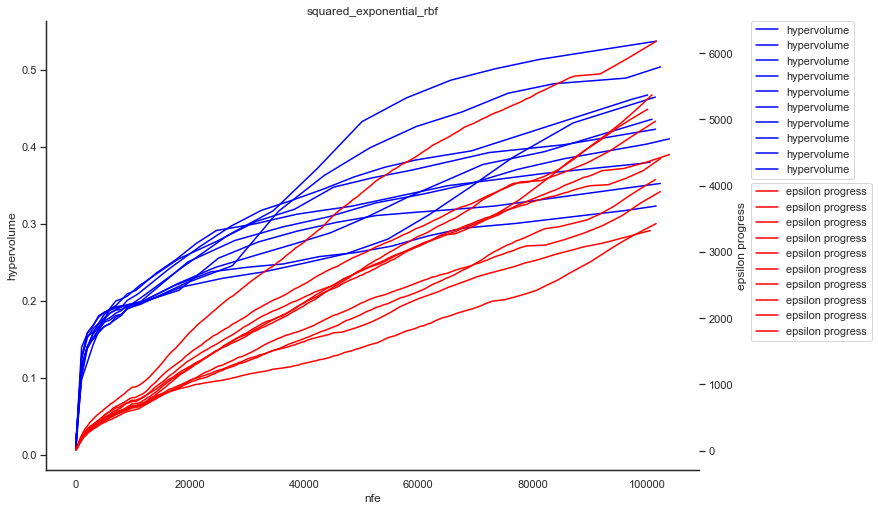

In [65]:
sns.set_style("white")

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dft_nfe, dft_hv, color= "blue", label="hypervolume")
ax2.plot(ep_nfe, ep_improv, color='red', label="epsilon progress")
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')
ax2.set_ylabel('epsilon progress')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
# ax2.legend(lines+lines2, ["Hypervolume","Epsilon Progress"], loc=0)
ax.set_title(rbf)
sns.despine()
# Put the legend out of the figure
ax.legend(bbox_to_anchor=(1.08, 1), borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.08, 0.64), borderaxespad=0.)


plt.show()

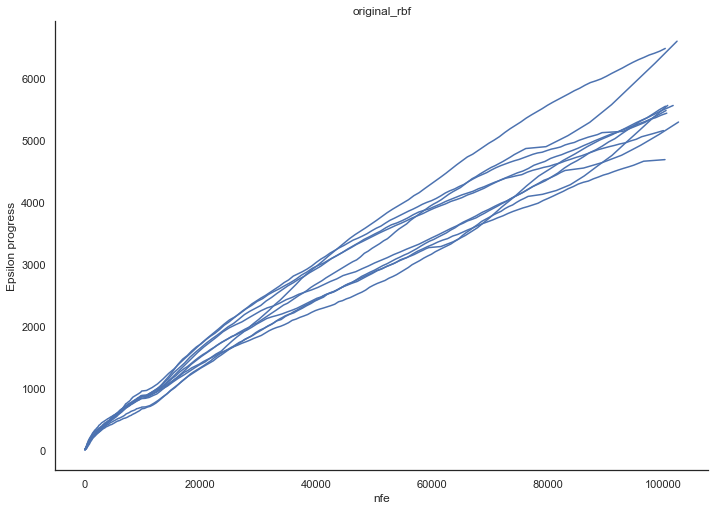

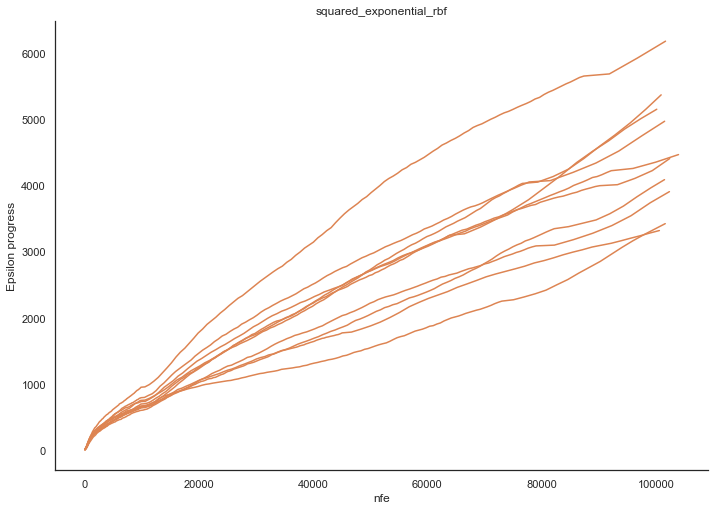

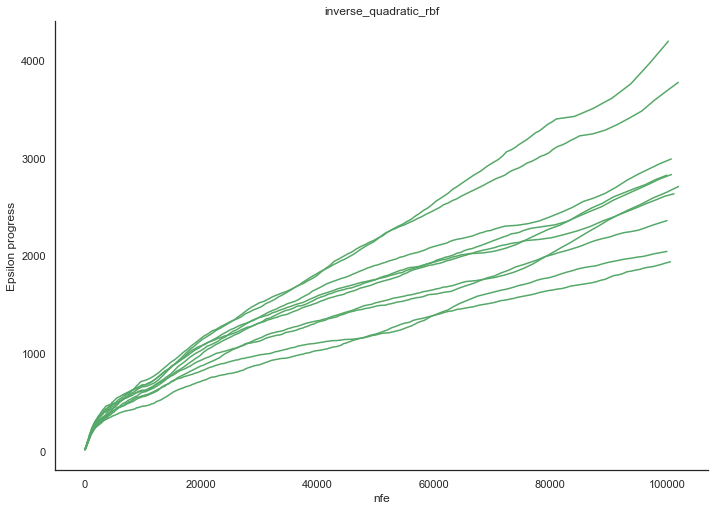

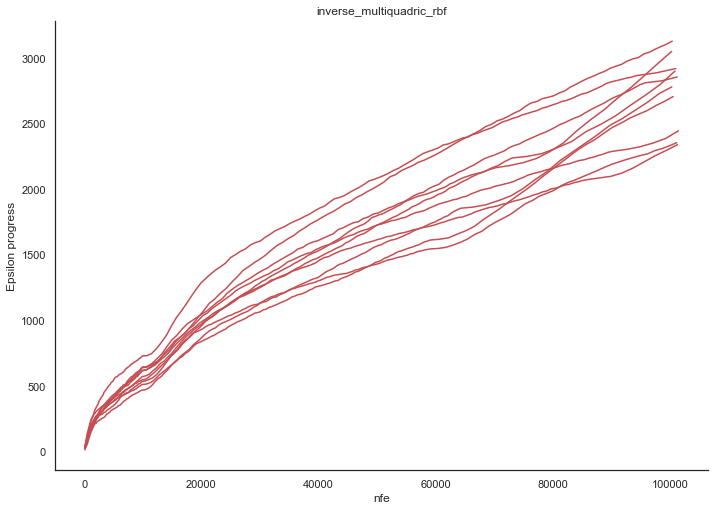

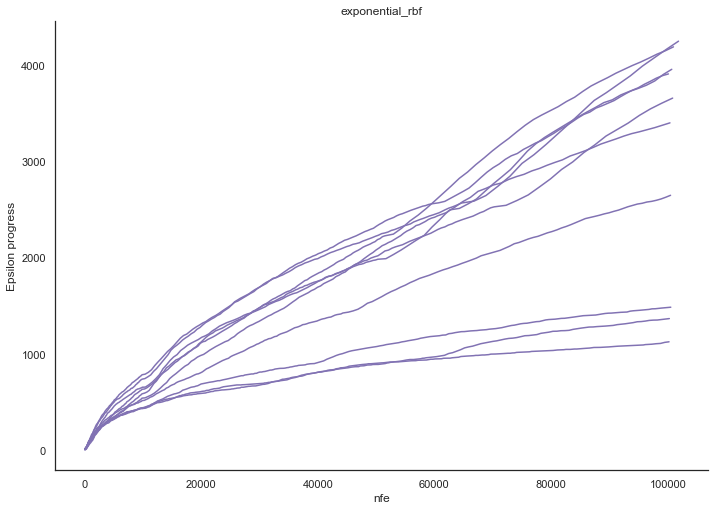

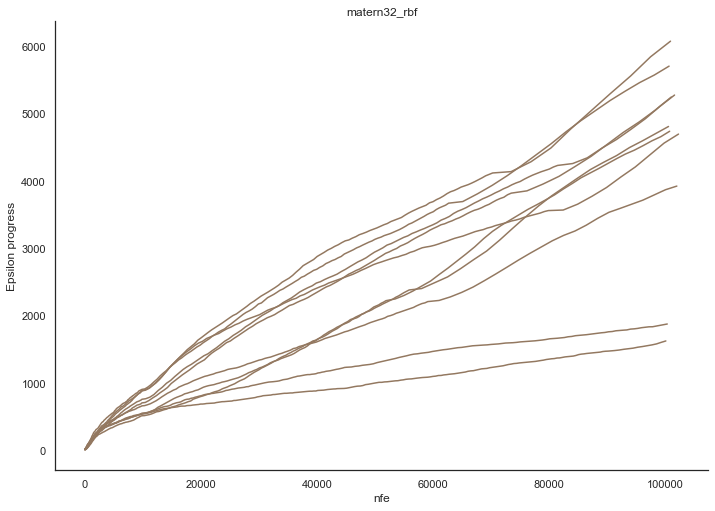

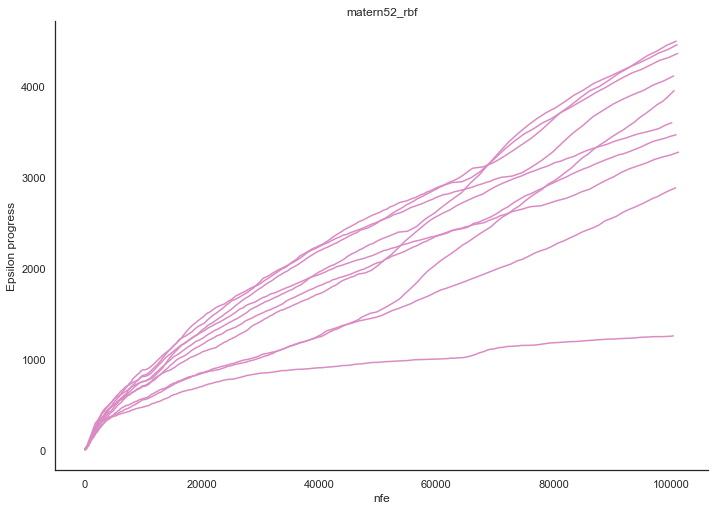

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    
    ep_nfe = {}
    ep_improv = {}
    output_dir = f"../output/{rbf}/"
    for i in os.listdir(output_dir):
        if i.endswith("_convergence.csv"):
            ep_load = pd.read_csv(output_dir + i)
            ep_nfe[int(i.split("_")[0])] = ep_load.nfe
            ep_improv[int(i.split("_")[0])]  = ep_load.improvements
    ep_nfe = pd.DataFrame.from_dict(ep_nfe)
    ep_improv = pd.DataFrame.from_dict(ep_improv)
    
    
    fig, ax = plt.subplots(sharex=True)
    ax.plot(ep_nfe, ep_improv, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon progress')
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f'figs/{rbf}/{rbf}_epsprog.jpg')
plt.show()

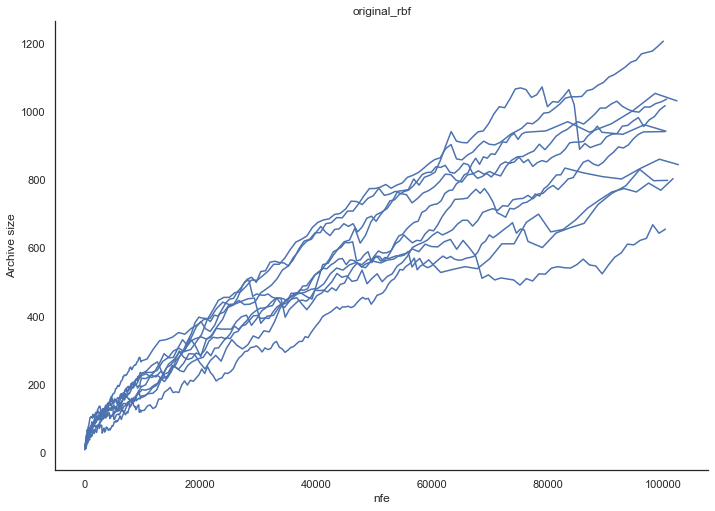

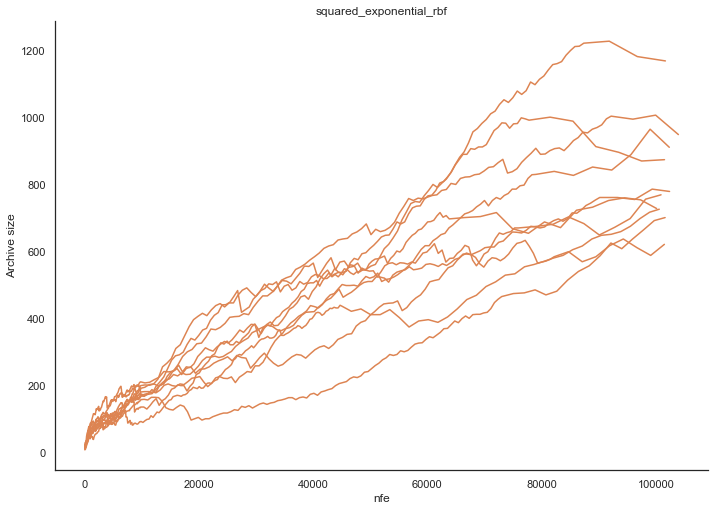

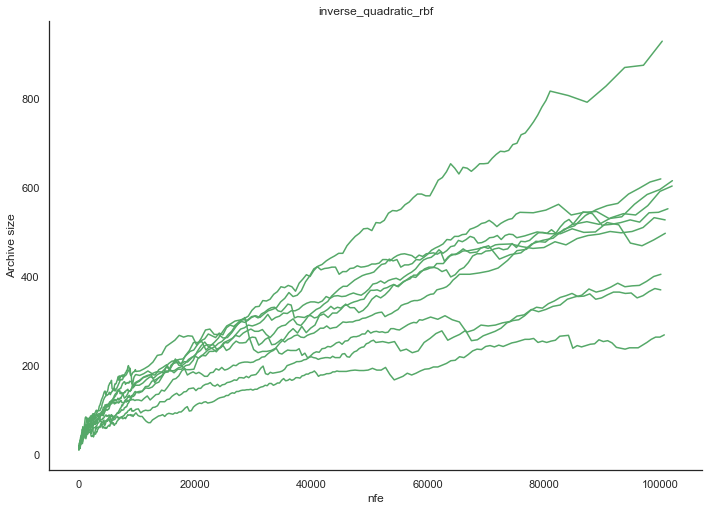

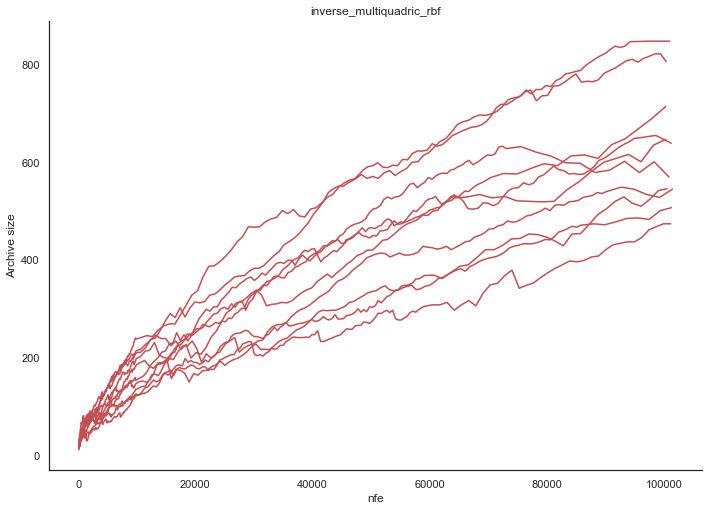

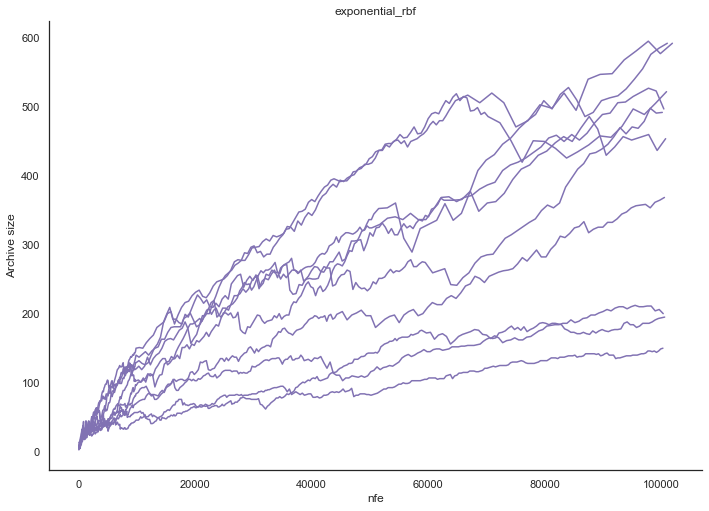

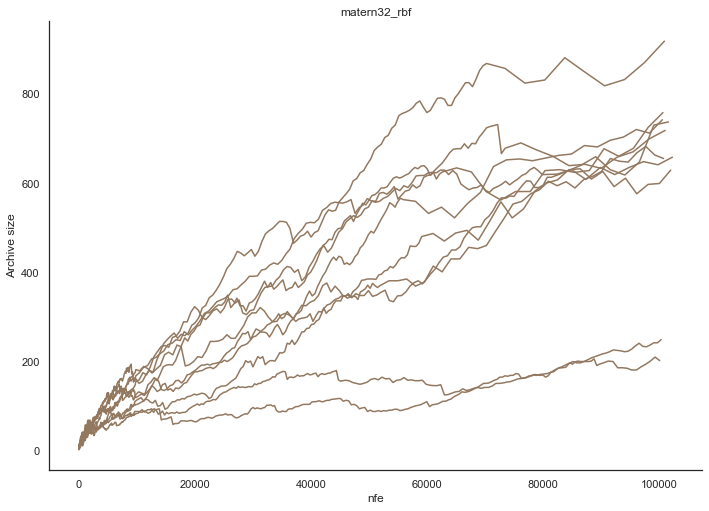

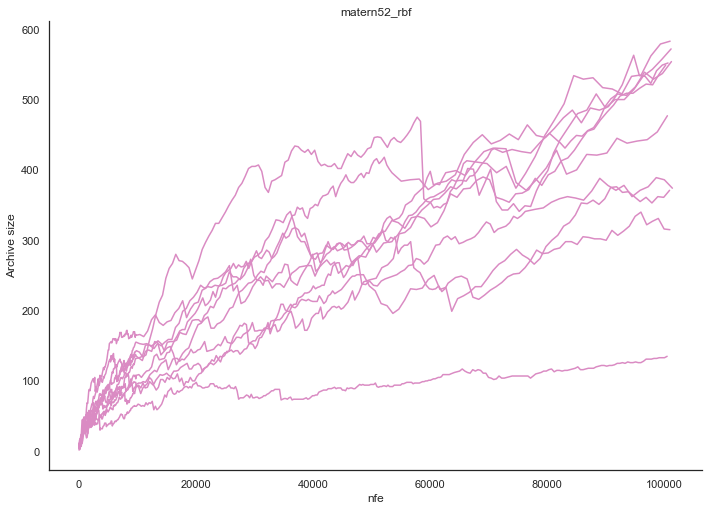

In [15]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    archive_nfe = {}
    archive_count = {}
    output_dir = f"../output/{rbf}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            dups = archives_by_nfe.pivot_table(columns=["Unnamed: 0"], aggfunc='size')
            archive_nfe[int(i.split("_")[0])] = dups.index
            archive_count[int(i.split("_")[0])] = dups.reset_index(drop=True)

    archive_nfe = pd.DataFrame.from_dict(archive_nfe, orient='index').T
    archive_size = pd.DataFrame.from_dict(archive_count, orient='index').T
    
    fig, ax = plt.subplots(sharex=True)
    ax.plot(archive_nfe, archive_size, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Archive size')
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f'figs/{rbf}/{rbf}_archsize.jpg')
plt.show()